# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
import pyspark
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql import Window

from pyspark.ml import Pipeline
from pyspark.ml.feature import MinMaxScaler, StandardScaler, VectorAssembler 
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator


import time
from datetime import datetime
import builtins as p

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## -- 1 -- Set up Spark environment

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("My Sparkify App") \
    .getOrCreate()

In [3]:
# check some information on the SparkContext
spark.sparkContext.getConf().getAll()

[('spark.app.id', 'local-1631775504711'),
 ('spark.driver.host', '51bba17814a8'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.port', '35633'),
 ('spark.app.name', 'My Sparkify App'),
 ('spark.ui.showConsoleProgress', 'true')]

#### Note:
The above output confirms that the current SparkSession can be run in the local mode of SparkContext.

In [4]:
# check basic information on the current SparkContext and SparkSession
spark

## -- 2 -- Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

### 2.1) Load the data

In [5]:
# load data
path = "mini_sparkify_event_data.json"
sparkify = spark.read.json(path)

In [6]:
# check the size of the dataset
print(
    "No. of rows:", sparkify.count(), ", No. of columns:", len(sparkify.columns))

No. of rows: 286500 , No. of columns: 18


In [7]:
# check feature names and data types in the dataset
sparkify.printSchema()

# alternatively: sparkify.describe()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



##### Initial observations:
- There are 286,500 records and 18 features in this dataset.
- `gender` could be turned into a 0-1 dummy from a string variable, for easier analysis.
- `firstName` and `LastName` can only be relevant together.
- If there is no missing data `userID` will be more useful for identifying users than the combination of `firstName` and `lastName` as there could be users living with the same name but using different `userID`s. However, one cannot exclude the opportunity that a real person uses Sparkify with more than one account.

In [8]:
# check the first record in the dataset
sparkify.take(1)

# alternatively: sparkify.show(n=1)
# alternatively: sparkify.head()

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')]

In [9]:
# check some values of an attribute
sparkify.select("level").show(3)

+-----+
|level|
+-----+
| paid|
| free|
| paid|
+-----+
only showing top 3 rows



### 2.2) Check the features

##### Next steps: get a general understanding of features
1. Check the number of unique values per features to assess whether e.g.:
    - numeric type data are really of a numeric nature and not some identifiers
    - string types of data are categorical variables or more diverse
2. Check the distribution of numeric data
3. Check all distinct values of categorical string data
4. Check some sample values of more diverse string data

#### 2.2.1.) Unique values per feature

In [10]:
# check the number of unique values in each attribute


i=1
for x in sparkify.columns:
    print(i, ".)", x)
    print(sparkify.select(x).distinct().count())
    i+=1

1 .) artist
17656
2 .) auth
4
3 .) firstName
190
4 .) gender
3
5 .) itemInSession
1322
6 .) lastName
174
7 .) length
14866
8 .) level
2
9 .) location
115
10 .) method
2
11 .) page
22
12 .) registration
226
13 .) sessionId
2354
14 .) song
58481
15 .) status
3
16 .) ts
277447
17 .) userAgent
57
18 .) userId
226


##### Comments:
- `registraton` and `userId` might be created together, assuming that a new user selects a `userId` at registration and the registration event has a unique identifier number. There are 226 identifiable registered users in the dataset. (Indeed, later evaluation clarifies that `registration` is a de facto timestamp, probably marking the date and time of registration.)
- The following features might be categorical variables: `auth`, `gender`, `level`, `method`, `page`, `status`.

In [11]:
# create lists of features
numeric_columns = list(set([c.name for c in sparkify.schema.fields if isinstance(c.dataType, LongType)
    or isinstance(c.dataType, DoubleType)]) - set(["status"]))
string_columns = [c.name for c in sparkify.schema.fields if isinstance(c.dataType, StringType)]
categorical_columns = ["auth", "gender", "level", "method", "page", "status"]
other_columns = list(set(sparkify.columns) - set(numeric_columns) - set(categorical_columns))

In [12]:
print("\n Numeric columns: {},\n Categorical columns: {}, \n Other columns: {}.".format(numeric_columns, categorical_columns, other_columns))


 Numeric columns: ['itemInSession', 'sessionId', 'registration', 'length', 'ts'],
 Categorical columns: ['auth', 'gender', 'level', 'method', 'page', 'status'], 
 Other columns: ['song', 'userAgent', 'firstName', 'artist', 'location', 'userId', 'lastName'].


##### Note:
Type of the following columns will require adjustment:
- `sessionId` should be of StringType
- `ts` should be of TimestampType
- `gender` should be a dummy of a numeric type, e.g. ShortType
- `status` should change to StringType.

#### 2.2.2.) Numeric data

In [13]:
# check the distribution of numeric data
sparkify.select(numeric_columns).describe().show()

+-------+------------------+-----------------+--------------------+-----------------+--------------------+
|summary|     itemInSession|        sessionId|        registration|           length|                  ts|
+-------+------------------+-----------------+--------------------+-----------------+--------------------+
|  count|            286500|           286500|              278154|           228108|              286500|
|   mean|114.41421291448516|1041.526554973822|1.535358834084427...|249.1171819778458|1.540956889810483...|
| stddev|129.76726201140994|726.7762634630741| 3.291321616327586E9|99.23517921058361|1.5075439608226302E9|
|    min|                 0|                1|       1521380675000|          0.78322|       1538352117000|
|    max|              1321|             2474|       1543247354000|       3024.66567|       1543799476000|
+-------+------------------+-----------------+--------------------+-----------------+--------------------+



##### Comment:
There are maximum 2,474 sessions, based on `sessionId` values, assuming that distinct values are assigned to distinct sessions.

#### 2.2.3.) Categorical data

In [14]:
# check distinct values in the seemingly categorical variables
cat_var_list = ["auth", "gender", "level", "page", "status"]

i=1
for x in cat_var_list:
    print(i)
    sparkify.select(x).distinct().show(n=22) #n=22 selected to show all unique values
    i+=1

1
+----------+
|      auth|
+----------+
|Logged Out|
| Cancelled|
|     Guest|
| Logged In|
+----------+

2
+------+
|gender|
+------+
|     F|
|  null|
|     M|
+------+

3
+-----+
|level|
+-----+
| free|
| paid|
+-----+

4
+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
| Submit Registration|
|            Settings|
|               Login|
|            Register|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+

5
+------+
|status|
+------+
|   307|
|   404|
|   200|
+------+



#### 2.2.4.) Other data

In [15]:
# check sample values in the userAgent column
sparkify.select("userAgent").take(5)

[Row(userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0'),
 Row(userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"'),
 Row(userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0'),
 Row(userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"'),
 Row(userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0')]

##### Comment:
`userAgent` will require significant feature engineering to become useful.

### 2.3) Duplicate records

In [16]:
# drop potentially duplicate records
# source: https://towardsdatascience.com/distinct-vs-dropduplicates-in-spark-3e28af1f793c
sparkify_distinct = sparkify.distinct()

# check whether there were any duplicate records
print("\n No. of rows in original dataset: {}. \n No. of rows in dataset cleaned from duplications: {}.".format(sparkify.count(), sparkify_distinct.count()))


 No. of rows in original dataset: 286500. 
 No. of rows in dataset cleaned from duplications: 286500.


##### Conclusion:
There were no completely duplicate records in the dataset.

### 2.4) Handle null/nan/blank values

#### 2.4.1) Null / nan values

In [17]:
# count null values per feature
# source: https://stackoverflow.com/questions/44413132/count-the-number-of-missing-values-in-a-dataframe-spark/44413456

sparkify_distinct.select(*(sum(col(c).isNull().cast("int"))\
                           .alias(c) for c in sparkify_distinct.columns)).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [18]:
# count Nan or missing values per feature
sparkify_distinct.select([count(when(isnan(c), c)).alias(c) for c in sparkify_distinct.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|     0|   0|        0|     0|            0|       0|     0|    0|       0|     0|   0|           0|        0|   0|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



In [19]:
# check the number of nan and null values
sparkify_distinct.select([count(when(isnan(c) | col(c).isNull(), c))\
                          .alias(c) for c in sparkify_distinct.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



##### Further observations:
- There are no Nan (missing) values in the dataset.
- There are no null values in the `userId` and the `sessionId` columns.
- There are at least 8,346 null values for 9 attributes.
- There are at least 58,392 null values for 3 attributes.
<br>

##### Considerations for dropping records or features:
- Dropping all the records for which some data is null would result in the loss of around 20% of the dataset (= 58,392/286,500).
- Dropping features for which there is at least one null value in the dataset would result in the loss of 50% of the features (= 9/18).
- The features for which there are around 20% null values are: `artist`, `length` and `song`. The event records for which these features are missing might simply be non-music-listening ones, e.g. registration (although it is not entirely clear at this point of cleaning / exploration which activities might be counted in one session).
- The features for which there are around 3% (= 8,346/286,500) null values are: `firstName`, `gender`, `lastName`, `location`, `registration` and `userAgent`.
    - As explained earlier, `firstName` and `lastName` combined are probably more or less equivalent with `userId`, i.e. no further relevant information should be expected from a specific name beyond identifying the user.
    - `gender` might predict some aspects of music streaming and churn behaviour therefore I will not drop it entirely. I will transform the F/M categorical string notation to a dummy variable (1 for female and 0 for male). 
    - `location` might add some relevant insights on churn behaviour therefore I will not drop this feature.
    - `registration` is a numeric value. Unfortunately, there is no data definition available for the dataset. However, based on the values in this features, it might be a kind of timestamp.
    - `userAgent` might be a resourceful feature to predict churn therefore I will not drop it from the dataset.
<br>   

##### Assumptions on the dataset:
- 80% of the records contains values for `artist`, `length` and `song` --> these might describe music listening events.
- There are events (20%) which do not contain data on music listening --> these might be of administrative nature, e.g. an upgrade / downgrade / cancellation and registration.
- There are events within the above category (3% of the total event amount) which only contain `auth` (e.g. cancelled, logged out), `itemInSession`, `level` (e.g. free or paid), `method` (e.g. get or put), `page` (e.g. About / Upgrade), status (probably HTTP status codes) data, beyond `userId`, `sessionId` and `ts` (timestamp). These could be all the administrative sessions except for registration.

#### 2.4.2) Blank values

In [20]:
# count the number of blank values per feature

for c in sparkify_distinct.columns:
    print("{} blank values in column '{}'.".format(sparkify_distinct.filter(col(c)=='').count(), c))

0 blank values in column 'artist'.
0 blank values in column 'auth'.
0 blank values in column 'firstName'.
0 blank values in column 'gender'.
0 blank values in column 'itemInSession'.
0 blank values in column 'lastName'.
0 blank values in column 'length'.
0 blank values in column 'level'.
0 blank values in column 'location'.
0 blank values in column 'method'.
0 blank values in column 'page'.
0 blank values in column 'registration'.
0 blank values in column 'sessionId'.
0 blank values in column 'song'.
0 blank values in column 'status'.
0 blank values in column 'ts'.
0 blank values in column 'userAgent'.
8346 blank values in column 'userId'.


##### Assessment:
It is only the column `userId` which contains blank values.

In [21]:
# check records with blank userIds
# source of idea to investigate: https://github.com/Lamiaka/sparkify/blob/master/1-Sparkify_data_exploration.ipynb
sparkify_blank_users = sparkify_distinct.filter("userId = ''")
sparkify_blank_users.take(100)

[Row(artist=None, auth='Logged Out', firstName=None, gender=None, itemInSession=1, lastName=None, length=None, level='free', location=None, method='GET', page='Help', registration=None, sessionId=246, song=None, status=200, ts=1538388594000, userAgent=None, userId=''),
 Row(artist=None, auth='Logged Out', firstName=None, gender=None, itemInSession=0, lastName=None, length=None, level='paid', location=None, method='GET', page='Home', registration=None, sessionId=236, song=None, status=200, ts=1538398122000, userAgent=None, userId=''),
 Row(artist=None, auth='Logged Out', firstName=None, gender=None, itemInSession=26, lastName=None, length=None, level='free', location=None, method='GET', page='Home', registration=None, sessionId=186, song=None, status=200, ts=1539006960000, userAgent=None, userId=''),
 Row(artist=None, auth='Logged Out', firstName=None, gender=None, itemInSession=30, lastName=None, length=None, level='free', location=None, method='GET', page='About', registration=None, s

In [22]:
# check distinct values in the blank_users subset
var_list = ["auth", "level", "method", "page"]

i=1
for x in var_list:
    print(i)
    sparkify_blank_users.select(x).distinct().show()
    i+=1

1
+----------+
|      auth|
+----------+
|Logged Out|
|     Guest|
+----------+

2
+-----+
|level|
+-----+
| free|
| paid|
+-----+

3
+------+
|method|
+------+
|   PUT|
|   GET|
+------+

4
+-------------------+
|               page|
+-------------------+
|               Home|
|              About|
|Submit Registration|
|              Login|
|           Register|
|               Help|
|              Error|
+-------------------+



##### Comments:
**Observations:** Blank `userId`s typically belong to the following type of values:
- `auth`: Logged Out, Guest 
- `level`: both paid and free appears among the values
- `method`: both GET and PUT appears among the values (the latter typically with the `page` Login)
- `page`: Help, Home, About, Login, Submit Registration, Register and Error

**Conclusion:** The events the above values describe are probably related to guest views on the site, registration and login. In the absence of `userID`, these records cannot add value to the understandng of user behaviour such as churn and neither seem to provide additional value to the analysis therefore I will drop them.

In [23]:
sparkify_distinct2 = sparkify_distinct.where(col("userId") != "")

In [24]:
# check if dropping was successful
sparkify_distinct2.select("userId").distinct().count()

225

### 2.5) Transform data

#### 2.5.1) Transform timestamps

In [25]:
#check format of the timestamp-like features
sparkify_distinct2.select(["ts", "registration"]).show(3)

+-------------+-------------+
|           ts| registration|
+-------------+-------------+
|1538373133000|1538304455000|
|1538373134000|1538304455000|
|1538384924000|1536287099000|
+-------------+-------------+
only showing top 3 rows



##### Note:
Dividing by 1000 might be necessary as the last three digits are seemingly all zeros thus the data in `ts` might be provided as milliseconds. <br>
Source: https://stackoverflow.com/questions/31134969/how-to-convert-unix-timestamp-to-date-in-spark

In [26]:
#check type of the timestamp-like features
sparkify_distinct2.select(["ts", "registration"]).printSchema()

root
 |-- ts: long (nullable = true)
 |-- registration: long (nullable = true)



In [27]:
# write function to transform timestamp
def make_timestamp(df_name, column_name, new_column_name):
    '''
    Function creates timestamp type date and time feature from unix format and long (numeric) type of timestamp.
    Inputs:
        df_name: name of the original Spark dataframe
        column_name: name of the original timestamp column
        new_column_name: name of the transformed timestamp column
    Output:    
        new_df: transformed dataframe that contains an additional column of the transformed timestamp
    '''
    new_df = df_name.withColumn(new_column_name, from_unixtime(col(column_name)/1000))
    new_df = new_df.withColumn(new_column_name,
        to_timestamp(col(new_column_name)))
    return new_df

In [28]:
#apply function to transform timestamp
sparkify_timestamped = make_timestamp(sparkify_distinct2, "ts", "timestamp")

In [29]:
#apply function to transform registration date to timestamp
sparkify_timestamped = make_timestamp(sparkify_timestamped, "registration", "registration_timestamp")

#### 2.5.2) Extract devices

In [30]:
sparkify_timestamped.select("userAgent").take(100)

[Row(userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.94 Safari/537.36"'),
 Row(userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.94 Safari/537.36"'),
 Row(userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"'),
 Row(userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"'),
 Row(userAgent='"Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"'),
 Row(userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"'),
 Row(userAgent='Mozilla/5.0 (compatible; MSIE 10.0; Windows NT 6.1; WOW64; Trident/6.0)'),
 Row(userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0

In [31]:
#extract data from userAgent

#write function to extract data on device type
def extract_device(x):
    '''
    Function extracts device information from userAgent strings.
    Input:
        x: agentUser string
    Output:
        "Windows" / "Mac" / "Linux" / "iPad" / "iPhone" / "Android" / "Other": device or operating system type
    '''
    if "Windows" in x:
        return "Windows"
    elif "Macintosh" in x:
        return "Mac"
    elif "Linux" in x: 
        return "Linux" #mostly PC but can be server or TV as well
    elif "iPad" in x:
        return "iPad"
    elif "iPhone" in x:
        return "iPhone"
    elif "Android" in x:
        return "Android" #might refer to Andriod mobile or tablet as well
    else:
        return "Undefined"

In [32]:
#create udf function from it
extract_device_udf = udf(lambda x: extract_device(x), StringType())

In [33]:
#apply udf function to extract devices
sparkify_with_devices = sparkify_timestamped.withColumn("device", extract_device_udf(sparkify_timestamped["userAgent"]))

In [34]:
sparkify_with_devices.select("device").show(5)

+-------+
| device|
+-------+
|Windows|
|Windows|
|    Mac|
|Windows|
|Windows|
+-------+
only showing top 5 rows



#### 2.5.3) Transform location

In [35]:
#check location data
sparkify_with_devices.select("location").take(10)

[Row(location='McAllen-Edinburg-Mission, TX'),
 Row(location='McAllen-Edinburg-Mission, TX'),
 Row(location='Tampa-St. Petersburg-Clearwater, FL'),
 Row(location='Morgantown, WV'),
 Row(location='Hartford-West Hartford-East Hartford, CT'),
 Row(location='Lexington-Fayette, KY'),
 Row(location='Allentown-Bethlehem-Easton, PA-NJ'),
 Row(location='Philadelphia-Camden-Wilmington, PA-NJ-DE-MD'),
 Row(location='Spokane-Spokane Valley, WA'),
 Row(location='Jackson, MS')]

In [36]:
#check number of unique values in location
sparkify_with_devices.select("location").distinct().count()

114

In [37]:
#collect location parts after comma in string
#source: https://stackoverflow.com/questions/39235704/split-spark-dataframe-string-column-into-multiple-columns
full_df = sparkify_with_devices
split_col = F.split(full_df["location"], ", ")
full_df = full_df.withColumn("area", split_col.getItem(1))

In [38]:
full_df.select(["location", "area"]).show(10)

+--------------------+-----------+
|            location|       area|
+--------------------+-----------+
|McAllen-Edinburg-...|         TX|
|McAllen-Edinburg-...|         TX|
|Tampa-St. Petersb...|         FL|
|      Morgantown, WV|         WV|
|Hartford-West Har...|         CT|
|Lexington-Fayette...|         KY|
|Allentown-Bethleh...|      PA-NJ|
|Philadelphia-Camd...|PA-NJ-DE-MD|
|Spokane-Spokane V...|         WA|
|         Jackson, MS|         MS|
+--------------------+-----------+
only showing top 10 rows



In [39]:
#check cleaned dataset
full_df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- registration_timestamp: timestamp (nullable = true)
 |-- device: string (nullable = true)
 |-- area: string (nullable = true)



In [40]:
#check the type of full_df
print("The type of full_df is", type(full_df),".")

The type of full_df is <class 'pyspark.sql.dataframe.DataFrame'> .


## -- 3 -- Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

### 3.1) Define churn
Churn := when `page` column value equals `Cancellation Confirmation`.

In [41]:
full_df = full_df.withColumn("churnEvent", when(col("page") == "Cancellation Confirmation", 1).otherwise(0))

In [42]:
full_df.select("churnEvent").distinct().show()

+----------+
|churnEvent|
+----------+
|         1|
|         0|
+----------+



In [43]:
#assign churn label to each record which belongs to a churner customer
full_df = full_df.withColumn("churnerUser", F.max("churnEvent").over(Window.partitionBy("UserId")))

### 3.2) Explore data

In [44]:
#create temporary view to enable SQL queries
full_df.createOrReplaceTempView("full_table")

Spark dataframes will be transformed into pandas dataframes to enable visualization by matplotlib.

#### 3.2.1) Check overall churn proportion

In [45]:
#count the number and calculate proportion of churners
userNumber = full_df.select("userId").distinct().count()
full_df.select("userId","churnerUser").distinct().groupby("churnerUser").count().withColumn("share", F.round(col("count")/lit(userNumber),2)).show()

+-----------+-----+-----+
|churnerUser|count|share|
+-----------+-----+-----+
|          1|   52| 0.23|
|          0|  173| 0.77|
+-----------+-----+-----+



In [46]:
#calculate the exact proportion of churners
churnProportion = full_df.filter(full_df["churnEvent"]==1).select("userId").distinct().count()/userNumber
churnProportion

0.2311111111111111

In [47]:
churn_count = full_df.select("userId","churnerUser").distinct().groupby("churnerUser").count()

In [48]:
churn_count_pd = churn_count.toPandas()
churn_count_pd

,churnerUser,count
0,1,52
1,0,173


In [49]:
churn_count_pd = churn_count_pd.rename(columns={"churnerUser":"Churned", "count":"No. of users"})
churn_count_pd

,Churned,No. of users
0,1,52
1,0,173


In [50]:
churn_count_pd = churn_count_pd.set_index("Churned", drop=False)
churn_count_pd

,Churned,No. of users
Churned,,
1,1,52
0,0,173


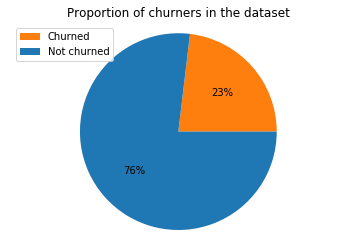

In [51]:
#create pie chart to show the proportion of churners in the dataset
plt.pie(churn_count_pd["No. of users"].values, colors=["tab:orange", "tab:blue"], autopct="%d%%")
plt.axis("equal")
plt.title("Proportion of churners in the dataset")
plt.legend(["Churned","Not churned"])
plt.show()

##### Comment:
The proportion of churn is ~23% in the dataset. As the label (`churnerUser`) in the models to be prepared is imbalanced F1 score will serve as a better model evaluation metrics than accuracy.

#### 3.2.2) Check churn across different features

In [52]:
#churners by gender
full_df.groupby("gender", "churnerUser").agg(countDistinct("userId")).show()

+------+-----------+----------------------+
|gender|churnerUser|count(DISTINCT userId)|
+------+-----------+----------------------+
|     M|          1|                    32|
|     F|          0|                    84|
|     F|          1|                    20|
|     M|          0|                    89|
+------+-----------+----------------------+



In [53]:
# churner proportion and gender
full_df.select("userId","gender","churnerUser").distinct().groupby("gender", "churnerUser").count().withColumn("share", F.round(col("count")/lit(userNumber),2)).show()

+------+-----------+-----+-----+
|gender|churnerUser|count|share|
+------+-----------+-----+-----+
|     M|          1|   32| 0.14|
|     F|          0|   84| 0.37|
|     F|          1|   20| 0.09|
|     M|          0|   89|  0.4|
+------+-----------+-----+-----+



##### Note:
These proportions refer to the complete dataset thus are not directly appropriate to compare the proportion of churners by gender.

In [54]:
gender_churner_pddf = full_df.groupby("gender", "churnerUser").agg(countDistinct("userId")).toPandas().rename(columns={"gender":"Gender", "churnerUser":"Type", "count(DISTINCT userId)":"No. of users"})

In [55]:
gender_churner_pddf

,Gender,Type,No. of users
0,M,1,32
1,F,0,84
2,F,1,20
3,M,0,89


In [56]:
gender_churner_pivot = gender_churner_pddf.pivot(index="Gender", columns="Type")["No. of users"]

In [57]:
gender_churner_pivot

Type,0,1
Gender,,
F,84,20
M,89,32


In [58]:
gender_churner_pivot2 = gender_churner_pivot
gender_churner_pivot2["Gender"]=gender_churner_pivot2.index
gender_churner_pivot2

Type,0,1,Gender
Gender,,,
F,84,20,F
M,89,32,M


In [59]:
gender_churner_pivot3 = gender_churner_pivot2
gender_churner_pivot3.index = [0,1]

In [60]:
gender_churner_pivot3

Type,0,1,Gender
0,84,20,F
1,89,32,M


In [61]:
gender_churner_pivot4 = gender_churner_pivot3.iloc[:, [2,0,1]]

In [62]:
gender_churner_pivot4 = gender_churner_pivot4.rename(columns={0:"Non-churner", 1:"Churner"})
#gender_churner_pivot4

In [63]:
gender_churner_pivot4["Total"] = gender_churner_pivot4["Non-churner"] + gender_churner_pivot4["Churner"]
df_total = gender_churner_pivot4["Total"]
gender_churner_pivot4

Type,Gender,Non-churner,Churner,Total
0,F,84,20,104
1,M,89,32,121


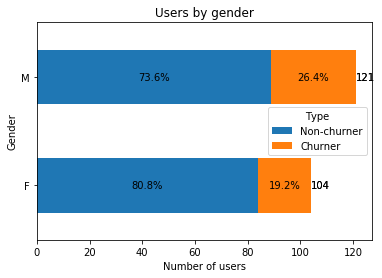

In [64]:
#source: https://stackoverflow.com/questions/51495982/display-totals-and-percentage-in-stacked-bar-chart-using-dataframe-plot

df_total = gender_churner_pivot4["Total"]
df = gender_churner_pivot4.iloc[:, 0:3]

df.plot(x = "Gender", kind='barh', stacked = True, title = 'Users by gender', mark_right = True)
plt.xlabel("Number of users")

df_rel = df[df.columns[1:]].div(df_total, 0)*100

for n in df_rel:
    for i, (cs, ab, pc, tot) in enumerate(zip(df.iloc[:, 1:].cumsum(1)[n], df[n], df_rel[n], df_total)):
        plt.text(tot, i, str(tot), va='center')
        plt.text(cs - ab/2, i, str(np.round(pc, 1)) + '%', va='center', ha='center')

In [65]:
# create a dummy for paid events
full_df = full_df.withColumn("paidEvent", when(col("level") == "paid", 1).otherwise(0))

In [66]:
full_df = full_df.withColumn("paidEverUser", F.max("paidEvent").over(Window.partitionBy("UserId")))

In [67]:
full_df.groupby("paidEverUser", "churnerUser").agg(countDistinct("userId")).show()

+------------+-----------+----------------------+
|paidEverUser|churnerUser|count(DISTINCT userId)|
+------------+-----------+----------------------+
|           1|          0|                   129|
|           1|          1|                    36|
|           0|          0|                    44|
|           0|          1|                    16|
+------------+-----------+----------------------+



In [68]:
level_churner_pddf = full_df.groupby("paidEverUser", "churnerUser").agg(countDistinct("userId")).toPandas().rename(columns={"paidEverUser":"Tried paid level", "churnerUser":"Type", "count(DISTINCT userId)":"No. of users"})
level_churner_pddf

,Tried paid level,Type,No. of users
0,1,0,129
1,1,1,36
2,0,0,44
3,0,1,16


In [69]:
level_churner_pivot = level_churner_pddf.pivot(index="Tried paid level", columns="Type")["No. of users"]
level_churner_pivot

Type,0,1
Tried paid level,,
0,44,16
1,129,36


In [70]:
level_churner_pivot["Tried paid level"] = level_churner_pivot.index
#level_churner_pivot

In [71]:
level_churner_pivot = level_churner_pivot.iloc[:,[2,0,1]]
#level_churner_pivot

In [72]:
level_churner_pivot = level_churner_pivot.rename(columns={0:"Non-churner", 1:"Churner"})
#level_churner_pivot

In [73]:
level_churner_pivot["Total"] = level_churner_pivot["Non-churner"] + level_churner_pivot["Churner"]
#level_churner_pivot

In [74]:
df_total = level_churner_pivot["Total"]
df = level_churner_pivot.iloc[:, 0:3]

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


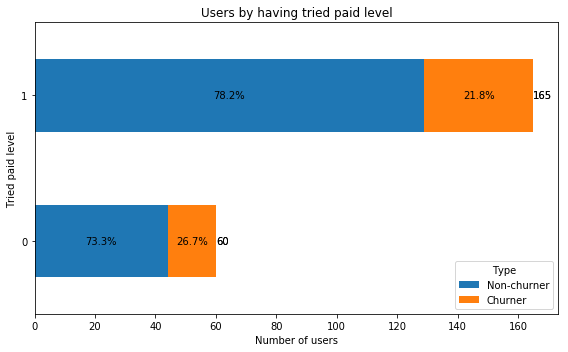

In [75]:
plt.rcParams["figure.figsize"] = [8, 5]
plt.rcParams["figure.autolayout"] = True

df.plot(x = "Tried paid level", kind='barh', stacked = True, title = 'Users by having tried paid level', mark_right = True)
plt.xlabel("Number of users")

df_rel = df[df.columns[1:]].div(df_total, 0)*100

for n in df_rel:
    for i, (cs, ab, pc, tot) in enumerate(zip(df.iloc[:, 1:].cumsum(1)[n], df[n], df_rel[n], df_total)):
        plt.text(tot, i, str(tot), va='center')
        plt.text(cs - ab/2, i, str(np.round(pc, 1)) + '%', va='center', ha='center')

In [76]:
# user distribution across areas
max_rows = full_df.select("area").distinct().count()
full_df.groupby("area", "churnerUser").agg(countDistinct("userId")).show(max_rows)

+-----------+-----------+----------------------+
|       area|churnerUser|count(DISTINCT userId)|
+-----------+-----------+----------------------+
|         IN|          0|                     2|
|      IL-MO|          1|                     1|
|         VA|          0|                     2|
|         MD|          0|                     1|
|         AZ|          0|                     5|
|      MN-WI|          0|                     3|
|         AZ|          1|                     2|
|      VA-NC|          0|                     1|
|         OK|          0|                     1|
|      RI-MA|          0|                     2|
|         TX|          1|                     3|
|      MA-NH|          0|                     5|
|         LA|          0|                     1|
|         NC|          0|                     5|
|         SC|          0|                     1|
|         AL|          0|                     2|
|      MO-IL|          1|                     1|
|         TX|       

In [77]:
area_churner_pddf = full_df.groupby("area", "churnerUser").agg(countDistinct("userId")).toPandas().rename(columns={
    "area":"Area", "churnerUser":"Type", "count(DISTINCT userId)":"No. of users"})
area_churner_pivot = area_churner_pddf.pivot(index="Area", columns="Type")["No. of users"]
area_churner_pivot["Area"] = area_churner_pivot.index
area_churner_pivot = area_churner_pivot.iloc[:,[2,0,1]]

area_churner_pivot = area_churner_pivot.rename(columns={0:"Non-churner", 1:"Churner"})
area_churner_pivot = area_churner_pivot.fillna(0)

In [78]:
area_churner_pivot["Total"] = area_churner_pivot["Non-churner"] + area_churner_pivot["Churner"]
area_churner_pivot = area_churner_pivot.sort_values(["Total"], ascending=False)

In [79]:
df_total = area_churner_pivot["Total"]

df = area_churner_pivot.iloc[:, 0:3]

/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


[Text(0,0,'CA'),
 Text(0,0,'TX'),
 Text(0,0,'NY-NJ-PA'),
 Text(0,0,'FL'),
 Text(0,0,'AZ'),
 Text(0,0,'CT'),
 Text(0,0,'NC-SC'),
 Text(0,0,'IL-IN-WI'),
 Text(0,0,'NC'),
 Text(0,0,'MO-IL'),
 Text(0,0,'MI'),
 Text(0,0,'PA-NJ-DE-MD'),
 Text(0,0,'MA-NH'),
 Text(0,0,'NY'),
 Text(0,0,'WA'),
 Text(0,0,'AL'),
 Text(0,0,'CO'),
 Text(0,0,'DC-VA-MD-WV'),
 Text(0,0,'GA'),
 Text(0,0,'IL'),
 Text(0,0,'IN'),
 Text(0,0,'OH'),
 Text(0,0,'MS'),
 Text(0,0,'MN-WI'),
 Text(0,0,'PA'),
 Text(0,0,'NV'),
 Text(0,0,'KY'),
 Text(0,0,'OR-WA'),
 Text(0,0,'VA-NC'),
 Text(0,0,'OH-KY-IN'),
 Text(0,0,'VA'),
 Text(0,0,'RI-MA'),
 Text(0,0,'SC'),
 Text(0,0,'AK'),
 Text(0,0,'NJ'),
 Text(0,0,'MT'),
 Text(0,0,'GA-AL'),
 Text(0,0,'MO-KS'),
 Text(0,0,'MD'),
 Text(0,0,'LA'),
 Text(0,0,'NH'),
 Text(0,0,'TN-VA'),
 Text(0,0,'WI'),
 Text(0,0,'AR'),
 Text(0,0,'IA'),
 Text(0,0,'UT-ID'),
 Text(0,0,'UT'),
 Text(0,0,'IL-MO'),
 Text(0,0,'SC-NC'),
 Text(0,0,'TN-MS-AR'),
 Text(0,0,'TN'),
 Text(0,0,'KY-IN'),
 Text(0,0,'PA-NJ'),
 Text(0,0,'M

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


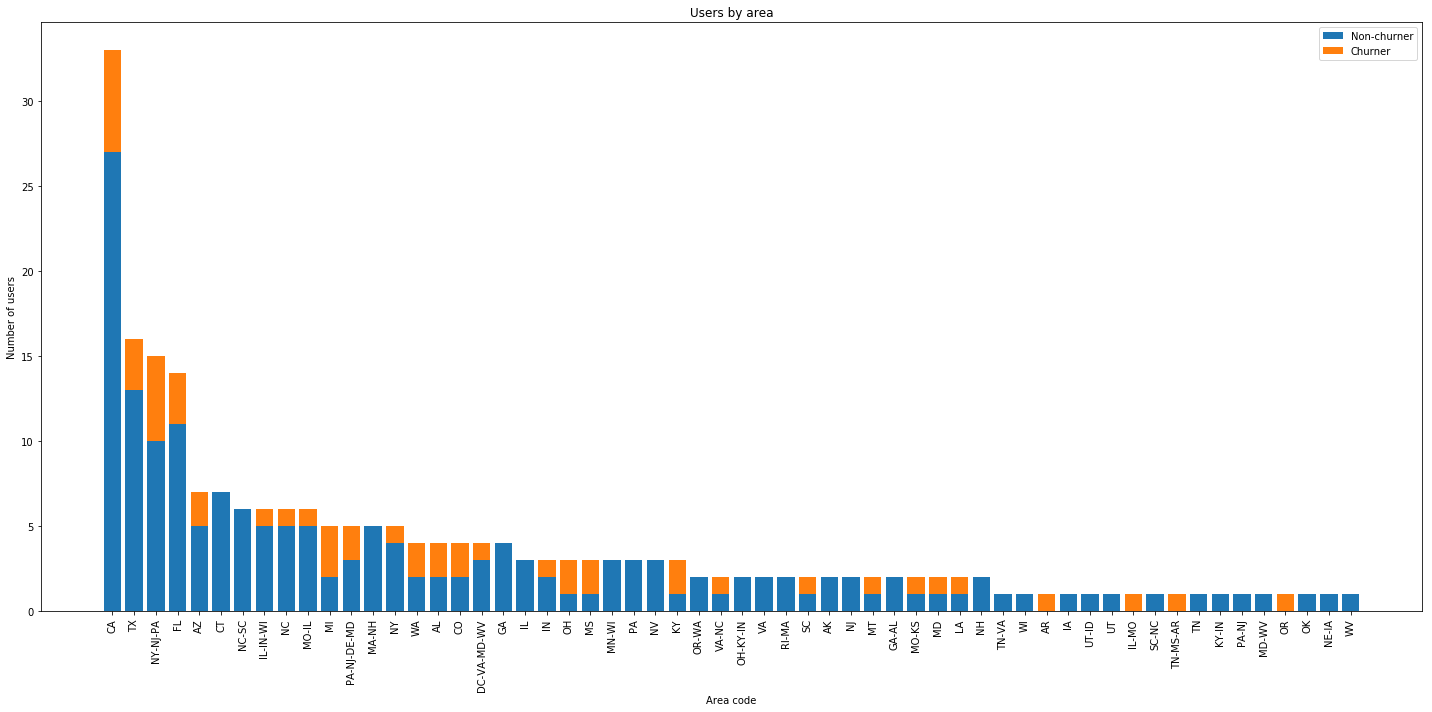

In [80]:
plt.figure(figsize=(20,10))
plt.bar(range(len(list(area_churner_pivot["Area"]))), list(area_churner_pivot["Non-churner"]), color="tab:blue")
plt.bar(
    range(len(list(area_churner_pivot["Area"]))),
    list(area_churner_pivot["Churner"]),
    bottom=list(area_churner_pivot["Non-churner"]),
    color="tab:orange")

plt.ylabel("Number of users")
plt.xlabel("Area code")
plt.title ("Users by area")
churnerType = ["Non-churner", "Churner"]
plt.legend(churnerType)

ax = plt.subplot()
ax.set_xticks(list(range(len(list(area_churner_pivot["Area"])))))
ax.set_xticklabels(list(area_churner_pivot["Area"]), rotation=90)

/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


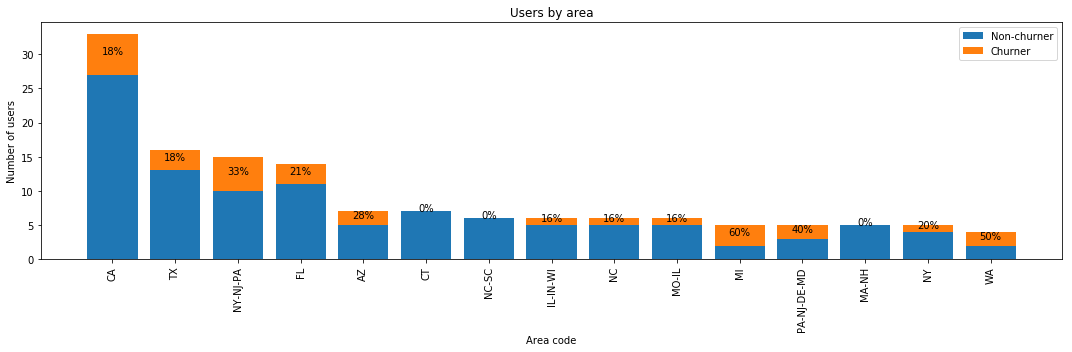

In [81]:
churnerNum = [int(x) for x in list(area_churner_pivot["Churner"]/area_churner_pivot["Total"]*100)]
churnerPercList = list()

for x in churnerNum:
    churnerPercList.append(str(x)+"%")

x_list = list(area_churner_pivot["Area"])[:15]
y1_list = list(area_churner_pivot["Non-churner"])[:15]
y2_list = list(area_churner_pivot["Churner"])[:15]
y_text = [y1 + y2/2 for y1,y2 in zip(y1_list, y2_list)][:15]

plt.figure(figsize=(15,5))
plt.bar(range(len(x_list)), y1_list, color="tab:blue")
plt.bar(
    range(len(x_list)),
    y2_list,
    bottom=y1_list,
    color="tab:orange")
plt.title("Users by area")
churnerType = ["Non-churner", "Churner"]
plt.legend(churnerType)
plt.xlabel("Area code")
plt.ylabel("Number of users")

ax = plt.subplot()
ax.set_xticks(list(range(len(x_list))))
ax.set_xticklabels(x_list, rotation=90)

for i in range(len(x_list)):
        plt.text(i, y_text[i], churnerPercList[i], ha = 'center')

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


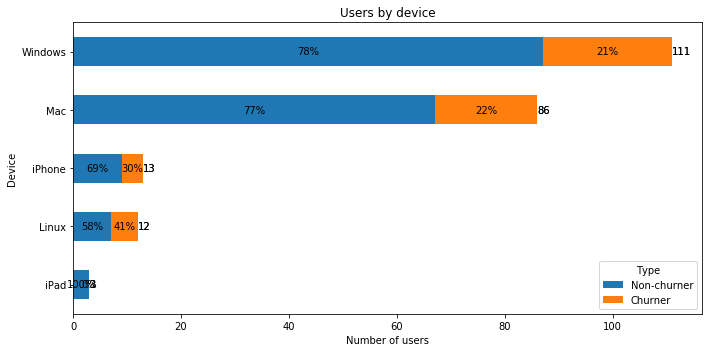

In [82]:
# churners by user agent
device_churner_pddf = full_df.groupby("device", "churnerUser").agg(countDistinct("userId")).toPandas().rename(
    columns={"device":"Device", "churnerUser":"Type", "count(DISTINCT userId)":"No. of users"})
device_churner_pivot = device_churner_pddf.pivot(index="Device", columns="Type")["No. of users"]
device_churner_pivot["Device"] = device_churner_pivot.index
device_churner_pivot = device_churner_pivot.iloc[:, [2,0,1]]
device_churner_pivot = device_churner_pivot.rename(columns={0:"Non-churner", 1:"Churner"})
device_churner_pivot = device_churner_pivot.fillna(0)
device_churner_pivot["Total"] = device_churner_pivot["Non-churner"] + device_churner_pivot["Churner"]
device_churner_pivot = device_churner_pivot.sort_values(["Total"], ascending=True)

plt.rcParams["figure.figsize"] = [10, 5]
plt.rcParams["figure.autolayout"] = True

df_total = [int(x) for x in device_churner_pivot["Total"]]
df = device_churner_pivot.iloc[:, 0:3]

plt.figure(figsize=(20,8))
df.plot(x = "Device", kind='barh', stacked = True, title = 'Users by device', mark_right = True)
plt.xlabel("Number of users")

df_rel = df[df.columns[1:]].div(df_total, 0)*100

for n in df_rel:
    for i, (cs, ab, pc, tot) in enumerate(zip(df.iloc[:, 1:].cumsum(1)[n], df[n], df_rel[n], df_total)):
        plt.text(tot, i, str(tot), va='center')
        plt.text(cs - ab/2, i, str(np.int(pc)) + '%', va='center', ha='center')

##### Comments:
- Regarding gender, there are 16% more men in the sample than women and churn proportion is larger among men than women.
- Regarding service level (free or paid), a large majority of users have tried the fee-paying version of Sparkify. Churn is slightly smaller among them (21.8%) than for those who only have tried the free version (26.7%).
- Regarding devices, based on the user agent information retrieved per event and aggregated at device and user level, 93% of users used Sparkify on desktop (based on the operating system). Churn proportion among users who used Sparkify on Windows or a Mac OS is slightly smaller (21-22%) though than those who used it from Linux (41%). If the sample size were not so small one could conclude that
  - either the Sparkify app tailored for Linux (assuming that Sparkify is not merely a webapp) is worse than that for Windows/Mac OS
  - or users who use Linux devices have remarkably different requirements or habits so that they tend to churn more.
- The dataset categorized the location of users at settlement level and at a more aggregated level, one that consisted of both US states and metropolitan areas. Considering the small size of the sample I only applied the more aggregated level for analysis. It is observable that most Sparkify users are located in states/metropolitan areas of the largest population such as California, Texas and the New York City and Philadelphia metropolitan areas. The proportion of user churn is widely varying among these areas (from 0 to 60%) but the differences might be solely due to sampling rather than underlying differences among users from different areas.

## -- 4 -- Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [83]:
#create user level dataset for further exploration
user_df = full_df.select("userID","churnerUser").distinct()

In [84]:
# create function to make dummy features from categorical variables that are static for a user
def dummyMakerFunction(records_df, ID_name, variable_name):
    '''
    Create dummy variable from a given variable.
    
    IN:
        records_df: dataframe of records
        ID_name: name of the column in the dataframe that shall be used as ID
        variable_name: name of the column for which dummy variables shall be made
        
    OUT:
        df: new dataframe consisting of columns of the ID and the dummy variables for the selected variable
    '''
    
    df = records_df.groupby(ID_name).pivot(variable_name).agg(F.lit(1)).na.fill(0)
    df = df.select([col(c).alias(variable_name+"_"+c) if c not in "userId" else c for c in df.columns])
    
    return df

In [85]:
# create dummy variables for the static categorical variables
gender_df = dummyMakerFunction(full_df, "userId", "gender")
area_df = dummyMakerFunction(full_df, "userId", "area")

# add these to the user-level dataframe
user_df = user_df.join(gender_df, "userId")\
                    .join(area_df, "userId")

In [86]:
# identify significant dates per user
ts_to_date = udf(lambda x: datetime.fromtimestamp(x / 1000.0), DateType())

regDate_df = full_df.select("userId", "registration").groupby("userId").agg(F.max("registration"))\
                    .withColumnRenamed("max(registration)", "timestamp_registration")\
                    .withColumn("date_registration", ts_to_date(col("timestamp_registration")))
lastDate_df = full_df.select("userId", "ts").groupby("userId").agg(F.max("ts"))\
                    .withColumnRenamed("max(ts)", "timestamp_last")\
                    .withColumn("date_last", ts_to_date(col("timestamp_last")))
date_df = regDate_df.join(lastDate_df, "userID")\
                    .withColumn("membership_days",\
                                ((col("timestamp_last")-col("timestamp_registration"))/86400000).cast(IntegerType()))
user_df = user_df.join(date_df, "userId")

In [87]:
# calculate session count and frequency
session_df = full_df.select("userId", "sessionId").groupby("userId").agg(countDistinct("sessionId"))\
                    .withColumnRenamed("count(DISTINCT sessionId)", "session_count")
user_df = user_df.join(session_df, "userId")
user_df = user_df.withColumn("visit_frequency", (col("session_count")/col("membership_days")))

In [88]:
# calculate max length between visits
# source: https://github.com/lingyanw/Sparkify_predict_churn/blob/master/Sparkify_churn.ipynb

def maxGapFinder(input_list):
    '''
    Function calculates the gap between every neighboring elements in a list and returns the largest gap.
    
    IN:
        input_list: a list of numbers (timestamps) to be compared
    OUT:
        maxGap: the numeric value of the largest gap
    '''
    sorted_list = sorted(input_list)
    gap_list = []
    
    if len(sorted_list)>1:
        for i in range(len(sorted_list)-1):
            gap_list.append(sorted_list[i+1] - sorted_list[i])
        maxGap = p.max(gap_list)
    else:
        maxGap = 0
        
    return maxGap

In [89]:
full_df = full_df.withColumn("ts_day", col("ts")/86400000)

maxLength_df = full_df.select("userId", "ts_day").groupby("userId").agg(F.collect_list("ts_day"))\
                        .withColumnRenamed("collect_list(ts_day)", "ts_day_list")

#source: https://sparkbyexamples.com/pyspark/pyspark-udf-user-defined-function/
maxGap_udf = udf(lambda x_list: maxGapFinder(x_list), DoubleType())
maxLength_df = maxLength_df.withColumn("max_gap_days", maxGap_udf(col("ts_day_list")))
user_df = user_df.join(maxLength_df, "userId")

In [90]:
# calculate event length metrics and add these to user-level dataframe
length_df = full_df.select("userId","length").groupby("userId").agg(
                    avg("length").alias("event_length_avg"),
                    F.max("length").alias("event_length_max"),
                    F.min("length").alias("event_length_min"),
                    F.sum("length").alias("event_length_sum")
)
user_df = user_df.join(length_df, "userId")

In [91]:
# calculate session length metrics and add these to user-level dataframe
session_length_df = full_df.select("userId", "sessionID", "length")\
                            .groupby("userID", "sessionID").agg(F.sum("length").alias("session_length"))\
                            .groupby("userID").agg(avg("session_length").alias("session_length_avg"),\
                                                   F.min("session_length").alias("session_length_min"),\
                                                   F.max("session_length").alias("session_length_max"))
user_df = user_df.join(session_length_df, "userId")

In [92]:
#calculate artist, song and event metrics
event_df = full_df.select("userId", "artist", "song", "length", "itemInSession").groupby("userId").agg(
                         count("artist").alias("artist_total"),\
                         count("song").alias("song_total"),\
                         count("length").alias("music_event_total"),\
                         F.sum("itemInSession").alias("item_total"),\
                         countDistinct("artist").alias("artist_distinct"),\
                         countDistinct("song").alias("song_distinct"),\
                         avg("itemInSession").alias("itemInSession_avg"),\
                         F.min("itemInSession").alias("itemInSession_min"),\
                         F.max("itemInSession").alias("itemInSession_max")
)

user_df = user_df.join(event_df,"userId")

In [93]:
#create page visit counts
page_df = full_df.select("userId", "page").groupby("userId").pivot("page").count().na.fill(value=0)
user_df = user_df.join(page_df, "userId")

In [94]:
# calculate the proportion of usage per device
device_df = full_df.select("userId", "device").groupby("userId").pivot("device").count().na.fill(value=0)
device_df = device_df.withColumn("devices_sum",\
                             (col("Linux")+col("iPad")+col("iPhone")+col("Mac")+col("Windows")))
device_df = device_df.withColumn("Linux_proportion", (col("Linux")/col("devices_sum")))\
                     .withColumn("Mac_proportion", (col("Mac")/col("devices_sum")))\
                     .withColumn("Windows_proportion", (col("Windows")/col("devices_sum")))\
                     .withColumn("iPad_proportion", (col("iPad")/col("devices_sum")))\
                     .withColumn("iPhone_proportion", (col("iPhone")/col("devices_sum")))
user_df = user_df.join(device_df, "userId")

In [95]:
# calculate some further potentially relevant metrics
user_df = user_df.withColumn("music_event_per_session_avg", (col("music_event_total")/col("session_count")))

In [96]:
#add the feature representing whether the user has ever tried the paid version
tried_paid_df = full_df.select("userId", "paidEverUser").distinct().withColumnRenamed("paidEverUser","tried_paid")
user_df = user_df.join(tried_paid_df, "userId")

### Drop unnecessary columns
from the user-level dataset

In [97]:
print("No. of rows at user level:", user_df.count(), ", No. of columns at user level:", len(user_df.columns))

No. of rows at user level: 225 , No. of columns at user level: 119


In [98]:
#drop columns that are not necessary for modeling
user_cols_to_drop = ("ts_day_list", "Linux", "Mac", "Windows", "iPad", "iPhone", "devices_sum",\
                     "gender_M", "iPhone_proportion", "Cancel", "Cancellation Confirmation", "date_registration", "date_last",\
                     'area_AK','area_AL','area_AR','area_CO','area_DC-VA-MD-WV','area_GA','area_GA-AL',\
                     'area_IA','area_IL','area_IL-MO','area_IN','area_KY','area_KY-IN','area_LA','area_MD',\
                     'area_MD-WV','area_MN-WI','area_MO-KS','area_MS','area_MT','area_NE-IA','area_NH','area_NJ',\
                     'area_NV','area_OH','area_OH-KY-IN','area_OK','area_OR','area_OR-WA','area_PA','area_PA-NJ',\
                     'area_RI-MA', 'area_SC', 'area_SC-NC', 'area_TN', 'area_TN-MS-AR', 'area_TN-VA', 'area_UT',\
                     'area_UT-ID', 'area_VA', 'area_VA-NC', 'area_WI','area_WV')
user_df_minor = user_df.drop(*user_cols_to_drop)

In [99]:
print("No. of rows for modeling:", user_df_minor.count(), ", No. of columns for modeling:", len(user_df_minor.columns))

No. of rows for modeling: 225 , No. of columns for modeling: 63


## -- 5 -- Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

##### Note:
While Scikit-learn performs well on small or medium-sized datasets to be processed on a single machine
paralell computing required for large datasets can be supported by Spark's machine learning libraries like the **pyspark.ml** module. Although the currently used 128 MB dataset does not require parallel computing nor are there multiple nodes set up for the current Spark Context the following code is prepared to be applicable for large datasets and parallel computing as well.

##### Selected models:
- Logistic Regression
- Random Forest Classification

### 5.1) Prepare evaluation forms

In [100]:
# create dataframe to collect model evaluation results
eval_metrics_list = []
eval_pddf = pd.DataFrame(eval_metrics_list)
eval_pddf["Evaluation metrics"] = ["Recall", "Precision", "F1 score", "Accuracy"]

### 5.2) Transform data for modeling
- Drop unnecessary ID
- Vectorize
- Scale
- Split to training and test sets

In [101]:
# drop unnecessary identifier column
df = user_df_minor.drop("userId")

In [102]:
# create a vectorAssembler to transform feature data
# as required for Spark ml modeling
features = df.columns[1:]

assembler = VectorAssembler(inputCols=features, outputCol="FeatureVec", handleInvalid="skip")
df_vec = assembler.transform(df)
df_vec = df_vec.select(col("FeatureVec").alias("features"),col("churnerUser").alias("label"))

In [103]:
# scale the data
# to avoid bias from skewed data

min_max_scaler = MinMaxScaler(inputCol = "features", outputCol = "FeatureVecScaled")
scalerModel = min_max_scaler.fit(df_vec)
df_scaled = scalerModel.transform(df_vec)
df_scaled = df_scaled.select(col("FeatureVecScaled").alias("features"), col("label"))

In [104]:
# split data into training and test sets
training_set, test_set = df_scaled.randomSplit([0.8,0.2])

### 5.3) Build and evaluate models

#### 5.3.1) Logistic Regression

In [105]:
lr_model_name = "Logistic Regression"

In [106]:
lr = LogisticRegression(maxIter=10, labelCol='label', featuresCol='features')

In [107]:
print("=========================== \n===========================")
print(lr_model_name)
print("---------------------------")
start_lr = time.time()
print('----- Start time of training the model: ', datetime.fromtimestamp(start_lr), ' -----')

lr_model = lr.fit(training_set)

end_lr = time.time()
print('----- Training the', lr_model_name, 'model took: ', end_lr-start_lr, ' second(s).-----')

Logistic Regression
---------------------------
----- Start time of training the model:  2021-09-16 07:49:04.516156  -----
----- Training the Logistic Regression model took:  221.83354139328003  second(s).-----


In [108]:
print("---------------------------")
start_lr2 = time.time()
print('----- Start time of predicting labels:', datetime.fromtimestamp(start_lr2), ' -----')

lr_prediction = lr_model.transform(test_set)

end_lr2 = time.time()
print('----- Predicting labels with the', lr_model_name, 'model took:', end_lr2-start_lr2, ' second(s).-----')

---------------------------
----- Start time of predicting labels: 2021-09-16 07:52:46.367620  -----
----- Predicting labels with the Logistic Regression model took: 0.12879252433776855  second(s).-----


In [109]:
evaluator = MulticlassClassificationEvaluator(labelCol ="label",predictionCol="prediction")

In [110]:
lr_accuracy = evaluator.evaluate(lr_prediction, {evaluator.metricName: "accuracy"})
lr_f1score = evaluator.evaluate(lr_prediction, {evaluator.metricName: "f1"})

In [111]:
print('Logistic Regression Metrics:')
print('Accuracy: {}'.format(lr_accuracy))
print('F-1 Score:{}'.format(lr_f1score))

Logistic Regression Metrics:
Accuracy: 0.8392857142857143
F-1 Score:0.8374829366727996


In [112]:
# check results in the confusion matrix
TP = lr_prediction.where(col("prediction")==1).where(col("label")==1).count()
FP = lr_prediction.where(col("prediction")==1).where(col("label")==0).count()
TN = lr_prediction.where(col("prediction")==0).where(col("label")==0).count()
FN = lr_prediction.where(col("prediction")==0).where(col("label")==1).count()

In [113]:
recall_calculated = TP / (TP + FN)

if TP + FP==0:
    precision_calculated = "There were not any churners in the test set nor among the predictions."
else:
    precision_calculated = TP / (TP + FP)


print("Recall: {}\nPrecision: {}".format(recall_calculated, precision_calculated))

Recall: 0.6666666666666666
Precision: 0.7142857142857143


In [114]:
if TP + FP==0:
    print("There were not any churners in the test set nor among the predictions.")
else:
    f1_calculated = (2*precision_calculated*recall_calculated)/(precision_calculated+recall_calculated)
    print("F1 score: {}".format(f1_calculated))

F1 score: 0.689655172413793


In [115]:
accuracy_calculated = (TP+TN)/(TP+FP+TN+FN)
print("Accuracy: {}".format(accuracy_calculated))

Accuracy: 0.8392857142857143


In [116]:
eval_pddf[lr_model_name] = [recall_calculated, precision_calculated, f1_calculated, accuracy_calculated]

### 5.3.2) Random Forest

In [117]:
rf_model_name = "Random Forest"
rf = RandomForestClassifier(numTrees=10, maxDepth=5, seed=42)

In [118]:
print("=========================== \n===========================")
print(rf_model_name)
print("---------------------------")
start_rf = time.time()
print('----- Start time of training the model: ', datetime.fromtimestamp(start_rf), ' -----')

rf_model = rf.fit(training_set)

end_rf = time.time()
print('----- Training the', rf_model_name, 'model took: ', end_rf-start_rf, ' second(s).-----')

Random Forest
---------------------------
----- Start time of training the model:  2021-09-16 08:11:45.559551  -----
----- Training the Random Forest model took:  439.4560148715973  second(s).-----


In [119]:
print("---------------------------")
start_rf2 = time.time()
print('----- Start time of predicting labels:', datetime.fromtimestamp(start_rf2), ' -----')

rf_prediction = rf_model.transform(test_set)

end_rf2 = time.time()
print('----- Predicting labels with the', rf_model_name, 'model took:', end_rf2-start_rf2, ' second(s).-----')

---------------------------
----- Start time of predicting labels: 2021-09-16 08:19:05.032727  -----
----- Predicting labels with the Random Forest model took: 0.09731721878051758  second(s).-----


In [120]:
rf_accuracy = evaluator.evaluate(rf_prediction, {evaluator.metricName: "accuracy"})
rf_f1score = evaluator.evaluate(rf_prediction, {evaluator.metricName: "f1"})
print(rf_model_name, 'Metrics:')
print('Accuracy: {}'.format(rf_accuracy))
print('F-1 Score:{}'.format(rf_f1score))

Random Forest Metrics:
Accuracy: 0.8035714285714286
F-1 Score:0.7583272697873716


In [121]:
# check results in the confusion matrix
TP_rf = rf_prediction.where(col("prediction")==1).where(col("label")==1).count()
FP_rf = rf_prediction.where(col("prediction")==1).where(col("label")==0).count()
TN_rf = rf_prediction.where(col("prediction")==0).where(col("label")==0).count()
FN_rf = rf_prediction.where(col("prediction")==0).where(col("label")==1).count()

In [122]:
recall_calculated_rf = TP_rf / (TP_rf + FN_rf)

if TP_rf + FP_rf==0:
    precision_calculated_rf = "There were not any churners in the test set nor among the predictions."
else:
    precision_calculated_rf = TP_rf / (TP_rf + FP_rf)

print("Recall: {}\nPrecision: {}".format(recall_calculated_rf, precision_calculated_rf))

Recall: 0.26666666666666666
Precision: 1.0


In [123]:
if TP_rf + FP_rf==0:
    print("There were not any churners in the test set nor among the predictions.")
else:
    f1_calculated_rf = (2*precision_calculated_rf*recall_calculated_rf)/(precision_calculated_rf+recall_calculated_rf)
    print("F1 score = {}".format(f1_calculated_rf))

F1 score = 0.4210526315789474


In [124]:
accuracy_calculated_rf = (TP_rf+TN_rf)/(TP_rf+FP_rf+TN_rf+FN_rf)
print("Accuracy: {}".format(accuracy_calculated_rf))

Accuracy: 0.8035714285714286


In [125]:
eval_pddf[rf_model_name] = [recall_calculated_rf, precision_calculated_rf, f1_calculated_rf, accuracy_calculated_rf]

### 5.3.3) Random Forest with larger minimum instances

In [126]:
# Try increasing recall on test set
# by increasing min leaf size
rf2_model_name = "Random Forest with a larger minimum leaf size"
rf2 = RandomForestClassifier(numTrees=10, maxDepth=5, minInstancesPerNode=5, seed=42)
#default minInstancesPerNode = 1

In [127]:
print("=========================== \n===========================")
print(rf2_model_name)
print("---------------------------")
start_rf2 = time.time()
print('----- Start time of training the model: ', datetime.fromtimestamp(start_rf2), ' -----')

rf2_model = rf2.fit(training_set)

end_rf2 = time.time()
print('----- Training the', rf2_model_name, 'model took: ', end_rf2-start_rf2, ' second(s).-----')

Random Forest with a larger minimum leaf size
---------------------------
----- Start time of training the model:  2021-09-16 08:37:57.415864  -----
----- Training the Random Forest with a larger minimum leaf size model took:  428.7433795928955  second(s).-----


In [128]:
print("---------------------------")
start_rf22 = time.time()
print('----- Start time of predicting labels:', datetime.fromtimestamp(start_rf22), ' -----')

rf2_prediction = rf2_model.transform(test_set)

end_rf22 = time.time()
print('----- Predicting labels with the', rf2_model_name, 'model took:', end_rf22-start_rf22, ' second(s).-----')

---------------------------
----- Start time of predicting labels: 2021-09-16 08:45:06.178743  -----
----- Predicting labels with the Random Forest with a larger minimum leaf size model took: 0.10353446006774902  second(s).-----


In [129]:
TP_rf2 = rf2_prediction.where(col("prediction")==1).where(col("label")==1).count()
FP_rf2 = rf2_prediction.where(col("prediction")==1).where(col("label")==0).count()
TN_rf2 = rf2_prediction.where(col("prediction")==0).where(col("label")==0).count()
FN_rf2 = rf2_prediction.where(col("prediction")==0).where(col("label")==1).count()

In [130]:
recall_calculated_rf2 = TP_rf2 / (TP_rf2 + FN_rf2)

if TP_rf2 + FP_rf2==0:
    precision_calculated_rf2 = "There were not any churners in the test set nor among the predictions."
else:
    precision_calculated_rf2 = TP_rf2 / (TP_rf2 + FP_rf2)

print("Recall: {}\nPrecision: {}".format(recall_calculated_rf2, precision_calculated_rf2))

Recall: 0.3333333333333333
Precision: 0.8333333333333334


In [131]:
if TP_rf2 + FP_rf2==0:
    print("There were not any churners in the test set nor among the predictions.")
else:
    f1_calculated_rf2 = (2*precision_calculated_rf2*recall_calculated_rf2)/(precision_calculated_rf2+recall_calculated_rf2)
    print("F1 score = {}".format(f1_calculated_rf2))

F1 score = 0.47619047619047616


In [132]:
accuracy_calculated_rf2 = (TP_rf2+TN_rf2)/(TP_rf2+FP_rf2+TN_rf2+FN_rf2)
print("Accuracy: {}".format(accuracy_calculated_rf2))

Accuracy: 0.8035714285714286


In [133]:
eval_pddf[rf2_model_name] = [recall_calculated_rf2, precision_calculated_rf2, f1_calculated_rf2, accuracy_calculated_rf2]

### 5.3) Compare model evaluation results

In [135]:
eval_pddf

,Evaluation metrics,Logistic Regression,Random Forest,Random Forest with a larger minimum leaf size
0,Recall,0.666667,0.266667,0.333333
1,Precision,0.714286,1.000000,0.833333
2,F1 score,0.689655,0.421053,0.476190
3,Accuracy,0.839286,0.803571,0.803571


##### Conclusion:
At a first running of the above script, the Logistic Regression and the first Random Forest models performed equally good although none of these performed objectively very well (62% for recall and 73% for F1). The exactly same performance might be explained by the very narrow test dataset (0.2 x 225 = 4.5 records) while the poor model performance by the sample size and the simple models applied.<break>
At the second running of the above script, the model performance results were somewhat different (as to be seen above in the printed results). Given that it is crucial for a streaming business to identify probable churners and act against their future churn I recommend choosing model based on its recall metrics besides F1 score as suggested by Udacity. Based on this, Logistic Regression seems to be the best (least worse in this case) model to predict customer churn.

### 5.5) Check Feature Importance

In [136]:
# extract feature importance
# source: https://www.silect.is/blog/random-forest-models-in-spark-ml/
importances = rf_model.featureImportances

In [137]:
feature_list = df.columns
feature_importance_pddf = pd.DataFrame(list(zip(feature_list, importances)), columns=['Feature', 'Importance'])

In [138]:
feature_importance_pddf = feature_importance_pddf.sort_values(by=["Importance"], ascending=False)

Text(0.5,1,'Feature importance')

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


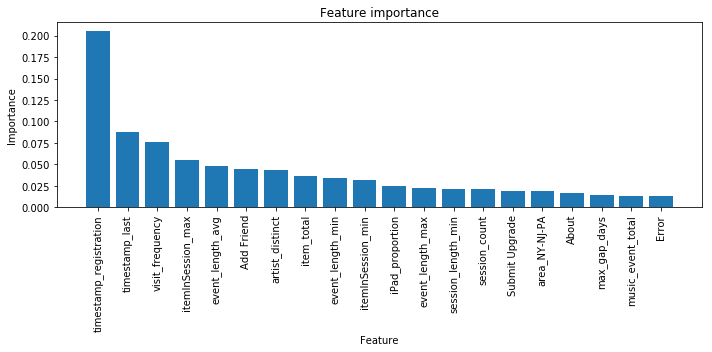

In [139]:
x_values = list(range(len(feature_importance_pddf["Feature"])))[:20]
feature_list = feature_importance_pddf["Feature"][:20]
plt.bar(x_values, feature_importance_pddf["Importance"][:20], orientation = "vertical")
plt.xticks(x_values, feature_list, rotation=90)
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.title("Feature importance")

In [141]:
# retrieve coefficients of the Logistic Regression model
# to check the direction how a feature affect the prediction
feature_coefficients = lr_model.coefficients.values.tolist()
feature_list2 = df.columns
feature_coefficients_pddf = pd.DataFrame(list(zip(feature_list2, feature_coefficients)), columns=['Feature', 'Coefficient'])
feature_coefficients_pddf = feature_coefficients_pddf.sort_values(by=["Coefficient"], ascending=False)

##### Comments:
Some of the formally most important features do not help better understand customer behavior such as:
- `timestamp_registration`
- `timestamp_last`.
<break><break>

While a more detailed analysis - only on a significantly larger sample - could explore patterns in the behavior of earlier vs. later adopters of the platform, in our case, the associated feature importance is probably just a bias due to the extent of available data (certainly, non-churners seem to stay longer in a given timeframe). This could be balanced if the churner and non-churner user base would be matching regarding the date of registration.
<break><break>

The top important features that seem reasonable are the following:
- `visit_frequency` (how often a user uses Sparkify) - Who uses Sparkify rarely is probably more prone to churn.
- `event_length_min` and `session_length_max` (what the minimum length of an event is for the user) - While we can assume that users who are listening to music for a very long time are more satisfied with the music streaming experience therefore the maximum length of sessions might be an indicator for their willingness to stay with Sparkify. The minimum length of an event, on the other hand, is less self-evident. E.g. it could mean that the user was dissatisfied that is why she jumped to another screen but it also could mean that the user can easily navigate through the application.

## -- 6 -- Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.